### Some useful Colab keyboard shorcuts
  




  * Show keyboard shortcuts: `ctrl+M+H`

---

We'll begin this lecture with a practical example of a neural network to understand essential components and concepts.

---


## A first look at a neural network
  

* An example of a neural network to learn to classify handwritten digits
* We will use the MNIST dataset.
  * 28*28 grayscale images, 10 categories
  * 60,000 training images, 10,000 test images
  * Refer to http://yann.lecun.com/exdb/mnist/
  * Solving MNIST is like the "hello world" of deep learning
* Note
  * In ML, a category in a classification problem is called a *class*.
  * Data points are called *samples*.
  * The class associated with a specific sample is called a *label*, *target* or *ground truth*.
* First, let's look into the MNIST dataset.

In [1]:
import torch
torch.__version__

'2.8.0+cu126'

In [2]:
!pip install --upgrade torch

In [3]:
!nvidia-smi

Mon Sep 15 05:50:36 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   44C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [4]:
import torch

In [15]:
from torchvision import datasets, transforms

train_data = datasets.MNIST(root='./data', train=True, download=True)
test_data = datasets.MNIST(root='./data', train=False, download=True)
# https://docs.pytorch.org/vision/main/generated/torchvision.datasets.MNIST.html

train_images, train_labels = train_data.data, train_data.targets
test_images, test_labels = test_data.data, test_data.targets

* The images are encoded as Numpy arrays, and the labels are an array of digits (0-9).
* The images and labels have a one-to-one correspondence.

In [16]:
print(type(train_images))

<class 'torch.Tensor'>


In [17]:
print('Shape of train_images array: ', train_images.shape)
print('# of training samples: ', len(train_images))

print('Shape of test_images array: ', test_images.shape)
print('# of test samples: ', len(test_images))

Shape of train_images array:  torch.Size([60000, 28, 28])
# of training samples:  60000
Shape of test_images array:  torch.Size([10000, 28, 28])
# of test samples:  10000


In [18]:
train_images[10]

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  42, 118, 219,
         166, 118, 118,   6,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 103, 242, 254, 254,
         254, 254, 254,  66,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   

In [19]:
train_images[10].shape

torch.Size([28, 28])

In [20]:
train_labels

tensor([5, 0, 4,  ..., 5, 6, 8])

In [21]:
train_labels.shape

torch.Size([60000])

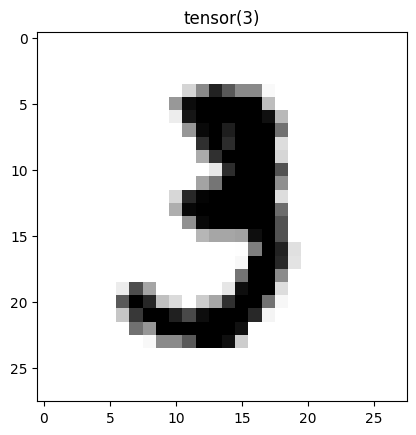

In [39]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
plt.style.use('default') # set the same default style as jupyter notebook

def visualize_mnist(image, label):
  plt.imshow(image, cm.binary)
  plt.title(label)
  plt.show()

visualize_mnist(train_images[10], train_labels[10])

* We'll feed the neural network the training data, `train_images` and `train_labels`.
* After training, we'll ask the network to produce predictions for `test_images`, and we'll verify whether these predictions match the labels from `test_labels`.
* Let's build the network.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x


In [3]:
!pip install -q torchinfo

In [4]:
from torchinfo import summary

model = SimpleNN()
summary(model)

Layer (type:depth-idx)                   Param #
SimpleNN                                 --
├─Linear: 1-1                            401,920
├─Linear: 1-2                            5,130
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0

* As we learned, the core building block of neural networks is the *layers*, a data-processing module.
* Specifically, layers extract *representations* out of the data fed into them.
* We can obtain more useful representations as training goes.


* Here, our network consists of a sequence of two `Linear` layers, which are densely connected (also called `fully connected`) layers.
* The last layer is a 10-way output layer, which produces 10 raw scores (called logits). These are not probabilities yet; the cross-entropy loss function will apply softmax to convert them into probabilities during training.


* To make the network ready for training, we need three more things,
  * A loss function
  * An optimizer
  * Metrics to monitor during training and testing

In [17]:
is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')
print('Current device is', device)

Current device is cuda


In [18]:
model = SimpleNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=1e-3)

def accuracy(logits, labels):
    preds = torch.argmax(logits, dim=1)
    return (preds == labels).float().mean()

* Before training, we'll define the data feeding pipeline using `Dataset` and `Dataloader`.
  * Instead of loading all arrays and preprocessing them upfront, we stream mini-batches from a `Dataset` with on-the-fly transforms.
  * Scaling to [0,1] is handled by `transforms.ToTensor()` (casts to `float32` and divides by 255).
  * Flattening from (1,28,28) -> (784) can be done either in the model or as a transform.

In [19]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# ToTensor(): uint8[0,255] -> float32[0,1], (H,W) -> (1,H,W)
# Lambda: (1,28,28) -> (784,)
train_tfms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda t: t.view(-1))  # flatten
])
test_tfms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda t: t.view(-1))
])

train_ds = datasets.MNIST(root="./data", train=True, download=True, transform=train_tfms)
test_ds  = datasets.MNIST(root="./data", train=False, download=True, transform=test_tfms)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True,  num_workers=0, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=256, shuffle=False, num_workers=0, pin_memory=True)

* Now, we are ready to train the network.

In [20]:
model.train()
for epoch in range(5):
    running_loss = 0.0
    running_acc = 0.0
    n_batches = 0

    for data, target in train_loader:
        data = data.to(device)
        target = target.to(device)

        optimizer.zero_grad()
        logits = model(data)
        loss = criterion(logits, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_acc  += accuracy(logits, target).item()
        n_batches += 1

    train_loss = running_loss / n_batches
    train_acc  = running_acc  / n_batches
    print("Epoch : {}\tLoss : {:3f}\tAcc : {:3f}".format(epoch, train_loss, train_acc))


Epoch : 0	Loss : 0.213554	Acc : 0.937883
Epoch : 1	Loss : 0.088478	Acc : 0.973264
Epoch : 2	Loss : 0.057449	Acc : 0.982276
Epoch : 3	Loss : 0.039944	Acc : 0.987623
Epoch : 4	Loss : 0.028961	Acc : 0.991005


* Two quantities are displayed during training, *loss* and *accuracy*.
* Note that these quantities do not guarantee the *test* performance.
* Let's check that the model performs well on the test set, too.

In [21]:
model.eval()
correct = 0
for data, target in test_loader:
    data, target = data.to(device), target.to(device)
    output = model(data)
    prediction = output.data.max(1)[1]
    correct += prediction.eq(target.data).sum()
print('Test set Accuracy : {:.2f}%'.format(100. * correct / len(test_loader.dataset)))

Test set Accuracy : 97.97%


* The test accuracy is a bit lower than the training accuracy.
* This gap between training accuracy and test accuracy is an example of *overfitting*.


* We saw how we can build and train a neural network to classify handwritten digits.

## Data representations for neural networks

* In the previous example, the data was stored in multidimensional Numpy arrays, also called *tensors*.
* In general, all current machine learning systems use tensors as their basic data structure.
* A tensor is a container for data.
* The number of *axes* (also called *dimensions*) of a tensor is called its *rank*.

> ### Scalars (0D tensors)

* A tensor that contains only one number is called a *scalar*.
* For example, a `float32` or `float64` number in Numpy is a scalar tensor.

In [22]:
import numpy as np
x = np.array(12)
x

array(12)

In [23]:
x.ndim

0

> ### Vectors (1D tensors)

* An array of numbers is called a *vector*, or 1D tensor.

In [24]:
x = np.array([12, 3, 6, 14, 5])
x

array([12,  3,  6, 14,  5])

In [25]:
x.ndim

1

* This vector has five entries and so is called a *5-dimensional vector*.
* Don't confuse a 5D vector with a 5D tensor!



> ### Matrices (2D tensors)

* An array of vectors is a *matrix*, or 2D tensor.
* A matrix has two axes (rows and columns).

In [26]:
x = np.array([[5, 78, 2, 34, 0],
              [6, 79, 3, 35, 1],
              [7, 80, 4, 36, 2]])
x

array([[ 5, 78,  2, 34,  0],
       [ 6, 79,  3, 35,  1],
       [ 7, 80,  4, 36,  2]])

In [27]:
x.ndim

2

In [28]:
x.shape

(3, 5)

> ### 3D tensors and higher-dimensional tensors

* An array of matrices? --> a 3D tensor
* It can be visually interpreted as a cube of numbers.

In [29]:
x = np.array([ [ [5, 78, 2, 34, 0],
                 [6, 79, 3, 35, 1],
                 [7, 80, 4, 36, 2] ],
               [ [5, 78, 2, 34, 0],
                 [6, 79, 3, 35, 1],
                 [7, 80, 4, 36, 2] ],
               [ [5, 78, 2, 34, 0],
                 [6, 79, 3, 35, 1],
                 [7, 80, 4, 36, 2] ] ])
print(x.ndim)
print(x.shape)

3
(3, 3, 5)


* By packing 3D tensors in an array, you can create a 4D tensor, and so on.
* In deep learning, you'll generally manipulate tensors that are 0D to 4D, although you may go up to 5D if you process video data.

> ### Key attributes

* *Number of axes (rank)*: the tensor's `ndim` in Numpy
* *Shape*: the tensor's `shape` in Numpy
* *Data type*: usually called `dtype` in Python libraries
  * This is the type of the data contained in the tensor: `float32`, `float64`, `uint8`, and so on.

In [35]:
train_data = datasets.MNIST(root='./data', train=True, download=True)
test_data = datasets.MNIST(root='./data', train=False, download=True)

train_images, train_labels = train_data.data, train_data.targets
test_images, test_labels = test_data.data, test_data.targets

train_images = train_images.numpy()

print(train_images.ndim)

3


In [36]:
print(train_images.shape)

(60000, 28, 28)


In [37]:
print(train_images.dtype)

uint8


* So, our `train_images` is a 3D tensor of 8-bit integers.
* More precisely, it is an array of 60,000 matrics of 28\*28 integers.
* Each matrix is a grayscale images, with elements between 0 and 255.

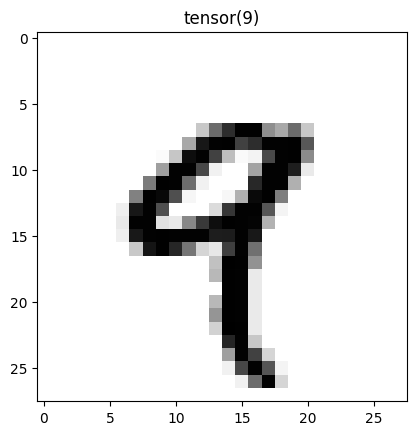

In [40]:
visualize_mnist(train_images[4], train_labels[4])

> ### Manipulating tensors in Numpy


* In the previous example, we selected a specific digit alongside the first axis using the syntax `train_images[i]`.
* Selecting specific elements in a tensor is called *tensor slicing*.

In [41]:
my_slice = train_images[10:100]
print(my_slice.shape)

(90, 28, 28)


In [42]:
my_slice = train_images[10:100, :, :] # : is equivalent to selecting the entire axis.
print(my_slice.shape)

my_slice = train_images[10:100, 0:28, 0:28]
print(my_slice.shape)

(90, 28, 28)
(90, 28, 28)


* If you want to select 14\*14 pixels in the bottom-right corner of all images:

In [43]:
my_slice = train_images[:, 14:, 14:]
print(my_slice.shape)

(60000, 14, 14)


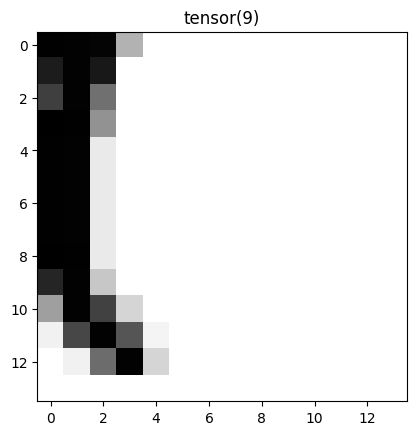

In [44]:
visualize_mnist(my_slice[4], train_labels[4])

* It is also possible to use negative indices.
* Negative indices indicate a position relative to the end of the current axis.
* For example, if you want to crop the images to patches of 14\*14 pixels centered in the middle:

In [45]:
np.array([0,1,2,3,4,5])[-2]

np.int64(4)

In [46]:
my_slice = train_images[:, 7:-7, 7:-7]
print(my_slice.shape)

(60000, 14, 14)


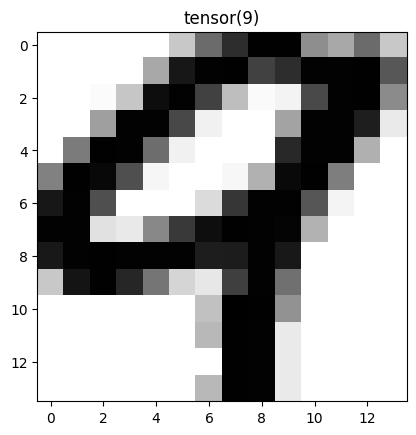

In [47]:
visualize_mnist(my_slice[4], train_labels[4])

> ### The notion of data batches

* In general, the first axis in all data tensors you'll come across in deep learning will be the *samples axis* (sometimes called the *samples dimension*, *batch axis* or *batch dimension*).
* In addition, deep learning models don’t process the entire dataset at once. Instead, a `DataLoader` streams the dataset in mini-batches. You simply iterate over the `DataLoader`, which yields `(inputs, labels)` tensors of the configured batch size (e.g., 128), handles shuffling, and takes care of the final, possibly smaller batch.

In [ ]:
for xb, yb in train_loader:
    # xb: (B, 784) float32 in [0,1]
    # yb: (B,)   int64 class labels
    # run forward/backward/optimizer.step()
    pass

> ### Real-world examples of data tensors


* Vector data - 2D tensors of shape `(samples, features)`
* Timeseries data or sequence data - 3D tensors of shape `(samples, timesteps, features)`
<img src="https://drive.google.com/uc?id=1-3Fn2PJjCWXMsROQMQ3qB62aRmRqbm74" width="800">
    
  * A dataset of stock prices
  * A dataset of tweets

* Images - 4D tensors of shape `(samples, height, width, channels)` or `(samples, channels, height, width)`
<img src="https://drive.google.com/uc?id=1-EK02MdPsB4MOmHf1dPENTUPkKpqZR3b" width="800">
   
  * A batch of 128 color images could be stored in a tensor of shape `(128, 256, 256, 3)`.
  * There are two conventions for shapes of images tensors: the *channels-last* convention and the *channels-first* convention.
  * For example, in Tensorflow, https://www.tensorflow.org/api_docs/python/tf/nn/convolution
* Video - 5D tensors of shape `(samples, frames, height, width, channels)` or `(samples, frames, channels, height, width)`
  * Each frame can be stored in a 3D tensor `(height, width, channels)`, a sequence of frames can be stored in a 4D tensor `(frames, height, width, channels)`, and thus a batch of different videos can be stored in a 5D tensor of shape `(samples, frames, height, width, channels)`.
  * For instance, a 60-second, 144\*256 YouTube video clip samples at 4 frames per second would have 240 frames. A batch of four such video clips would be stored in a tensor of shape `(4, 240, 144, 256, 3)`. --> A total of 106,168,320 values!
  * If the `dtype` of the tensor was `float32`, then each value would be stored in 32 bits, so the tensor would represent 405MB.

## The gears of neural networks: tensor operations

* All transformations learned by deep neural networks can be reduced to a handful of *tensor operations* applied to tensors of numeric data.
* In our initial example, we were building our network by stacking `Dense` layers on top of each other.
  * `keras.layers.Dense(512, activation='relu')`
* This layer can be interpreted as a function. Specifically, the function is:
  * `output = relu(dot(W, input) + b)` where `W` is a 2D tensor and `b` is a vector.
  * We have three tensor operations here:
    * A dot product (`dot`) between the input tensor and a tensor named `W`
    * An addition (`+`) between the resulting 2D tensor and a vector `b`
    * A `relu` operation of `relu(x)=max(x, 0)`

> ### Element-wise operations


* The `relu` operation and addtion are `element-wise` operations.
* If we write a naive Python implementation of `relu` using `for` loop:

In [ ]:
def naive_relu(x):
  assert len(x.shape) == 2 # x is a 2D Numpy tensor.

  x = x.copy() # to avoid overwriting the input tensor
  for i in range(x.shape[0]):
    for j in range(x.shape[1]):
      x[i, j] = max(x[i, j], 0)
  return x

* We can do the same thing for addtion:

In [ ]:
def naive_add(x, y):
  assert len(x.shape) == 2
  assert x.shape == y.shape

  x = x.copy()
  for i in range(x.shape[0]):
    for j in range(x.shape[1]):
      x[i, j] += y[i, j]
  return x

* In practice, these operations are provided as built-in Numpy functions, which are well-optimized via BLAS (Basic Linear Algebra Subprograms) implemented in Fortran or C.
* So, in Numpy, you can do the following element-wise operations very efficiently.
  ```python
  import numpy as np
  z = x+y
  z = np.maximum(z, 0.)
  ```
  

> ### Broadcasting

* What happens with addition when the shapes of the two tensors being added differ?
  * In our `naive_add` implementation, it only supports the addition of 2D tensors with identical shapes.
* When possible, and if there's no ambiguity, the smaller tensor will be *broadcasted* to match the shape of the larger tensor.
* Broadcasting consists of two steps:
  * Axes (called *broadcast axes*) are added to the smaller tensor to match the `ndim` of the larger tensor.
  * The smaller tensor is repeated alognside these new axes to match the full shape of the larger tensor.
* For example, consider `X` with shape `(32, 10)` and `y` with shape `(10,)`.
  * First, we add an empty first axis to `y`. --> The shape of `y` becomes `(1,10)`.
  * Then, we repeat `y` 32 times alongside this new axis. --> We get `Y` with shape of `(32,10)` where `Y[i, :] == y` for `i` in `range(0,32)`.
  * Now, we can proceed to add `X` and `Y`.
* Note that the repetition operation is entirely virtual: it happens at the algorithmic level rather than at the memory level.
* Here is what a naive implementation would look like:

In [ ]:
def naive_add_matrix_and_vector(x, y):
  assert len(x.shape) == 2
  assert len(y.shape) == 1
  assert x.shape[1] == y.shape[0]

  x = x.copy()
  for i in range(x.shape[0]):
    for j in range(x.shape[1]):
      x[i, j] += y[j]
  return x

* With broadcasting, we can generally apply two-tensor element-wise operations if one tensor has shape `(a, b, ..., n, n+1, ..., m)` and the other has shape `(n, n+1, ..., m)`.
* The broadcasting will then automatically happen for axes `a` through `n-1`.
* Example: the element-wise `maximum` operation to two tensors of different shapes via broadcasting

In [ ]:
import numpy as np

x = np.random.random((64, 3, 32, 10))
y = np.random.random((10,))
z = np.maximum(x, y)

In [ ]:
print(y)

[0.80652492 0.85132886 0.13638803 0.55177141 0.06940284 0.90881542
 0.5270101  0.78581118 0.83440423 0.25812784]


> ### Tensor dot

* The dot operation, also called a *tensor product* is the most common, most useful tensor operation.
* An element-wise product is done with the `*` operator in most libraries including Numpy, Keras, and Tensorflow.
* In both Numpy ans Keras, the dot operation uses the standard `dot` operator.
  ```python
  import numpy as np
  z = np.dot(x, y)
  ```
* The dot product of two vectors `x` and `y`

In [ ]:
def naive_vector_dot(x, y):
  assert len(x.shape) == 1
  assert len(y.shape) == 1
  assert x.shape[0] == y.shape[0]

  z = 0.
  for i in range(x.shape[0]):
    z += x[i] * y[i]
  return z

* The dot product between a matrix `x` and a vector `y`

In [ ]:
import numpy as np

def naive_matrix_vector_dot(x, y):
  assert len(x.shape) == 2
  assert len(y.shape) == 1
  assert x.shape[1] == y.shape[0] # Note that if x is a shape of (m,n),
                                  # then y should be a shape of (n,).

  z = np.zeros(x.shape[0])
  for i in range(x.shape[0]):
    for j in range(x.shape[1]):
      z[i] += x[i, j] * y[j]
  return z

In [ ]:
def naive_matrix_vector_dot(x, y):
  z = np.zeros(x.shape[0])
  for i in range(x.shape[0]):
    z[i] = naive_vector_dot(x[i, :], y)
  return z

* Note that if one of two tensors has an `ndim` greater than 1, `dot` operations is no longer symmetric: `dot(x, y) != dot(y, x)`.
* The dot product of two matrices `x` and `y`, `dot(x, y)`
  * It can be computed if and only if `x.shape[1] == y.shape[0]`.
  * The result is a matrix with shape `(x.shape[0], y.shape[1])`, where the coefficients are the vector products between the rows of `x` and the columns of `y`.
<img src="https://drive.google.com/uc?id=1-JJJvURzHAvBvwUB7W2uU7U_DchkxJ9C" width="800">



In [ ]:
def naive_matrix_dot(x, y):
  assert len(x.shape) == 2
  assert len(y.shape) == 2
  assert x.shape[1] == y.shape[0]

  z = np.zeros((x.shape[0], y.shape[1]))
  for i in range(x.shape[0]):
    for j in range(y.shape[1]):
      row_x = x[i, :]
      column_y = y[:, j]
      z[i, j] = naive_vector_dot(row_x, column_y)
  return z

* More generally, we can take the dot product between higher-dimensional tensors.
```
(a, b, c, d) . (d,) --> (a, b, c)
(a, b, c, d) . (d, e) --> (a, b, c, e)
```

> ### Tensor reshaping

* In our first neural network example, we used *reshaping* operation when we preprocessed the digits data before feeding it into the network.
```python
train_images = train_images.reshape((60000, 28*28))
```
* Reshaping means rearranging its rows and columns to match a target shape.

In [ ]:
x = np.array([ [0, 1],
               [2, 3],
               [4, 5] ])
print(x.shape)

(3, 2)


In [ ]:
x = x.reshape((6, 1))
print(x)

[[0]
 [1]
 [2]
 [3]
 [4]
 [5]]


In [ ]:
x = x.reshape((2, 3))
print(x)

[[0 1 2]
 [3 4 5]]


In [ ]:
x = x.reshape((3, 4))
print(x)

ValueError: cannot reshape array of size 6 into shape (3,4)

* A special case of reshaping is *transposition*.
* *Transposing* a matrix means exchanging its rows and its columns, so that `x[i, :] --> x[:, i]`.

In [ ]:
x = np.zeros((300, 20))
x = np.transpose(x)
print(x.shape)

(20, 300)


> ### Geometric interpretation of tensor operations

* The contents of the tensors manipulated by tensor operations --> coordinates of points in some geometric space.
* Therefore, all tensor operations have a geometric interpretation.
* Geometric interpretation of the sum of two vectors
<img src="https://drive.google.com/uc?id=1-Kl6QeLYfXli-lfOiJTC0yzrmtUVGqHX" width="800">

* In general, elementary geometric operations such as translation, rotation, scaling, skewing, and so on can be expressed as tensor operations.
  * Translation
  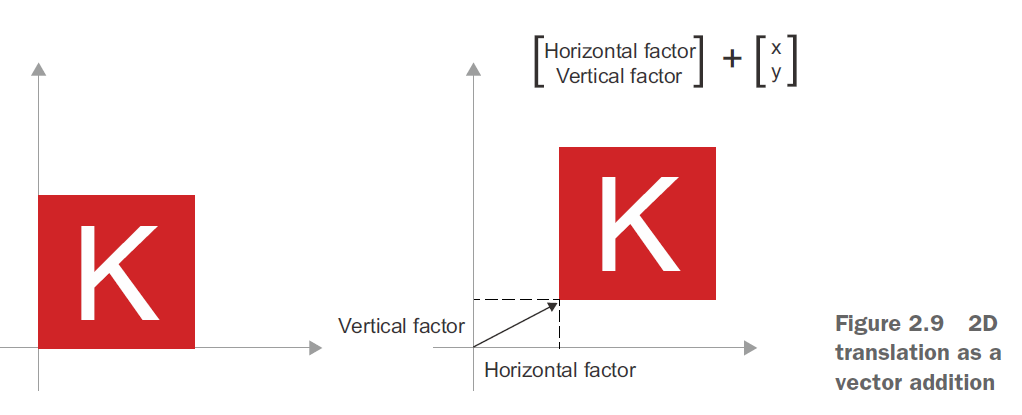
  * Rotation
  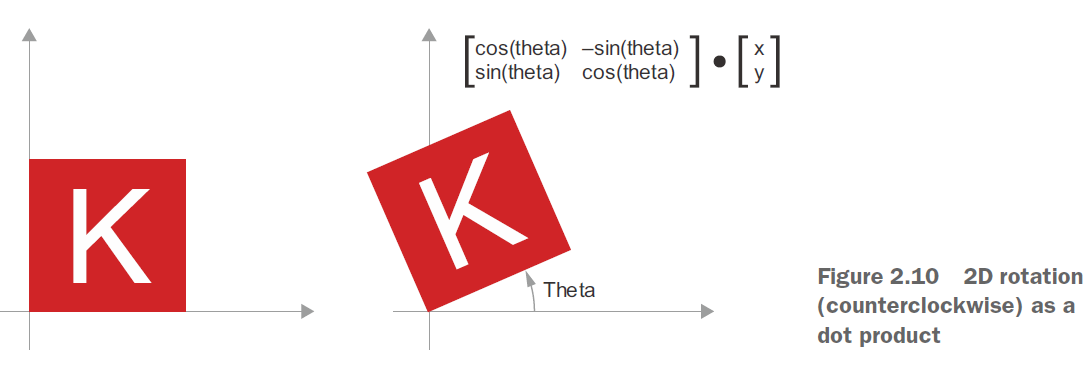
  * Scaling
  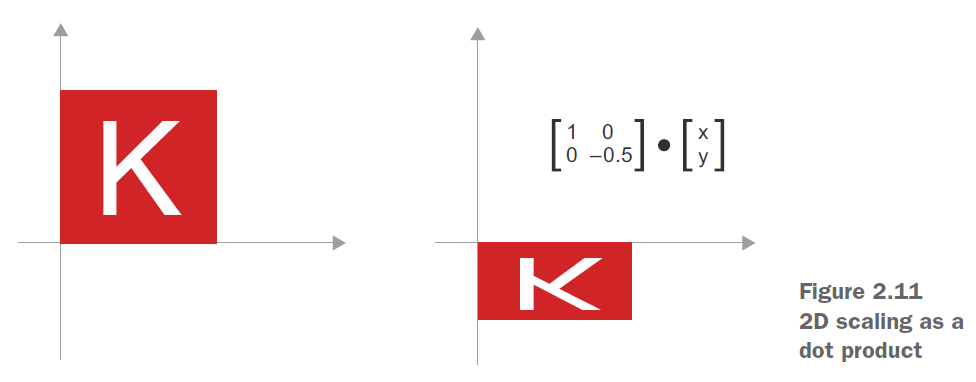
  * Linear transform
    * A dot product with an arbitrary matrix, e.g., scaling and rotation
  * Affine transform
  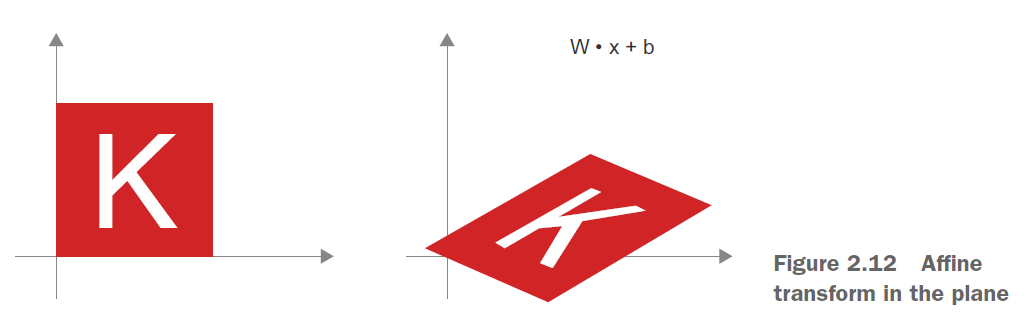
  * *Dense* layer with *relu* activation
    * Applying afffine transformations repeatedly, then?
      * affine2(affine1(x)) = W2̇(W1x+b1)+b2 = (W2W1)x+(W2b1b2)
    * A multilayer NN made entirely of *Dense* layers without activations would be equivalent to a single *Dense* layer.
  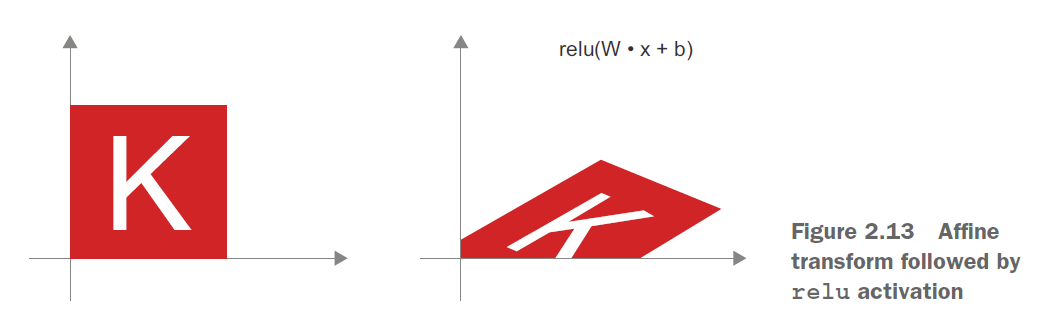

In [ ]:
import numpy as np

x = np.array([2, 0])
rotation = np.array([ [0, -1],
                      [1,  0] ])
z = np.dot(rotation, x) # Careful about the order!
print(z)

[0 2]


In [ ]:
np.dot(x, rotation)

array([ 0, -2])

In [ ]:
rotation * x

array([[0, 0],
       [2, 0]])

In [ ]:
x * rotation

array([[0, 0],
       [2, 0]])

> ### A geometric interpretation of deep learning

* We just learned that neural networks consist entirely of chains of tensor operations and that all of these tensor operations are just geometric transformations of the input data.
* We can interpret a neural network = very complex geometric transformation.
* Image two sheets of colored paper, one red and one blue, and put one on top of the other.
  * Now crumple them together into a small ball.
  * That crumpled paper ball is your input data, and each sheet of paper is a class of data in a classification problem.
  * What a NN is meant to do is figure out a transformation of the paper ball that would uncrumple it, so as to make the two classes clearnly separable again.
  * Uncrumpling paper balls is what machine learning is about: finding neat representations for complex, highly folded data *manifolds* in high-dimensional spaces (a manifold is a continuous surface, like our crumpled sheet of paper).
  * Deep learning takes the approach of incrementally decomposing a complicated geometric transformation into a long chain of elementary ones, which is pretty much the strategy a human would follow to uncrumple a paper ball.
  * Each layer in a deep network applies a transformation that disentangles the data a little, and a deep stack of layers makes tractable an extremely complicated disentanglement process.
  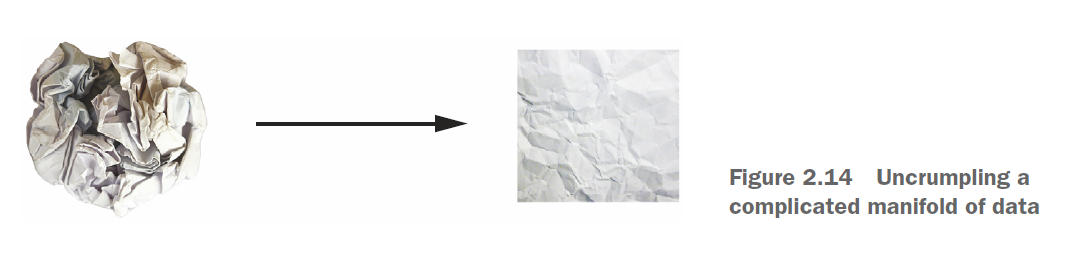


## Reading assignments

* Section 2.1 and 2.3 in "Dive into deep learning"